## Library

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from scipy.stats import gmean
import random
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras # Packages# Load Data
import keras
from tensorflow.keras.layers import *#Reshape, Flatten, Input, concatenate, Embedding, Conv1D
from tensorflow.keras.layers import *#RNN, LSTM, GRU, Dense, Embedding, Input, BatchNormalization, LeakyReLU, Dropout, ReLU
from tensorflow.keras.models import *#Sequential, Model, load_model, model_from_json
from keras.regularizers import *
from keras.optimizers import *
from keras.initializers import *
from keras.preprocessing import sequence
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import * #Adam, RMSprop, Nadam
from tensorflow.keras.utils import CustomObjectScope
from keras.utils.np_utils import *
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import TomekLinks, RandomUnderSampler, NearMiss, EditedNearestNeighbours, CondensedNearestNeighbour

print(tf.__version__)

C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


2.2.0


## Load Data

In [2]:
data = pd.read_csv('data/기상병합.csv')
testdata = pd.read_csv('data/test_기상병합.csv')

print(data.shape)
print(testdata.shape)

(342732, 18)
(3539, 17)


## Preprocessing

In [3]:
train1 = data.drop(['plant_train.mea_ddhr', 
                      'plant_train.cond_loc', 'plant_test.x24h_tma', 'plant_train.x24h_cond_loc',
                      'plant_test.x48h_tma', 'plant_train.x48h_cond_loc'], axis = 1)
train2 = data.drop(['plant_train.mea_ddhr', 
                      'plant_train.cond_loc', 'plant_test.x24h_tma', 'plant_train.x24h_cond_loc',
                      'plant_test.x48h_tma', 'plant_train.x48h_cond_loc'], axis = 1)
train_label_24 = np.array(data.loc[:,'plant_train.x24h_cond_loc'])
train_label_48 = np.array(data.loc[:,'plant_train.x48h_cond_loc'])

#### Undersampling

In [4]:
und24 = RandomUnderSampler(random_state = 2)
und48 = RandomUnderSampler(random_state = 2)

In [5]:
X_24, y_24 = und24.fit_sample(train1, train_label_24)
X_48, y_48 = und48.fit_sample(train2, train_label_48)

In [6]:
X_24 = pd.DataFrame(X_24, columns = ['plant_train.plant', 'plant_train.loc', 'plant_train.tem_in',
       'plant_train.hum_in', 'plant_train.tem_coil_in',
       'plant_train.tem_out_loc1', 'plant_train.hum_out_loc1', '기온(°C)',
       '풍향(deg)', '풍속(m/s)', '강수량(mm)', '습도(%)'])
X_48 = pd.DataFrame(X_48, columns=['plant_train.plant', 'plant_train.loc', 'plant_train.tem_in',
       'plant_train.hum_in', 'plant_train.tem_coil_in',
       'plant_train.tem_out_loc1', 'plant_train.hum_out_loc1', '기온(°C)',
       '풍향(deg)', '풍속(m/s)', '강수량(mm)', '습도(%)'])

#### Preprocessing

In [7]:
# 학습에 필요없는 열 제거
train24 = X_24.drop(['plant_train.plant', 'plant_train.loc'], axis = 1)
train48 = X_48.drop(['plant_train.plant', 'plant_train.loc'], axis = 1)
test = testdata.drop(['plant_test.mea_ddhr', 'plant_test.plant', 'plant_test.loc',
                      'plant_test.x24h_tma', 'plant_test.x24h_cond_loc',
                      'plant_test.x48h_tma', 'plant_test.x48h_cond_loc'], axis = 1)

# 학습에 사용할 조건을 분리(0 부터 시작해야 to_categorical 함수가 제대로 작동함)
train_con1_24 = np.array(X_24.loc[:,'plant_train.plant'])-1
train_con2_24 = np.array(X_24.loc[:,'plant_train.loc'])-1

train_con1_48 = np.array(X_48.loc[:,'plant_train.plant'])-1
train_con2_48 = np.array(X_48.loc[:,'plant_train.loc'])-1

test_con1 = np.array(testdata.loc[:,'plant_test.plant'])-1
test_con2 = np.array(testdata.loc[:,'plant_test.loc'])-1

# target 분리
train_label_24 = y_24
train_label_48 = y_48

In [8]:
# 조건을 one-hot encoding
train_con1_24 = tf.keras.utils.to_categorical(train_con1_24, num_classes=2)
train_con2_24 = tf.keras.utils.to_categorical(train_con2_24, num_classes=3)

train_con1_48 = tf.keras.utils.to_categorical(train_con1_48, num_classes=2)
train_con2_48 = tf.keras.utils.to_categorical(train_con2_48, num_classes=3)

test_con1 = tf.keras.utils.to_categorical(test_con1, num_classes=2)
test_con2 = tf.keras.utils.to_categorical(test_con2, num_classes=3)

print(train_con1_24.shape)
print(train_con2_24.shape)
print(train_con1_48.shape)
print(train_con2_48.shape)
print(test_con1.shape)
print(test_con2.shape)

(3906, 2)
(3906, 3)
(3908, 2)
(3908, 3)
(3539, 2)
(3539, 3)


#### Scaling

In [9]:
SS24 = StandardScaler()
SS48 = StandardScaler()

train24 = SS24.fit_transform(train24)
train48 = SS48.fit_transform(train48)

test24 = SS24.transform(test)
test48 = SS48.transform(test)

In [10]:
# 입력 데이터를 사용할 모델에 맞게 차원을 추가
train24 = np.reshape(np.array(train24), [train24.shape[0], 1, train24.shape[1]])
train48 = np.reshape(np.array(train48), [train48.shape[0], 1, train48.shape[1]])

test24 = np.reshape(np.array(test24), [test24.shape[0], 1, test24.shape[1]])
test48 = np.reshape(np.array(test48), [test48.shape[0], 1, test48.shape[1]])

train_con1_24 = np.reshape(train_con1_24, [train_con1_24.shape[0], 1, train_con1_24.shape[1]])
train_con2_24 = np.reshape(train_con2_24, [train_con2_24.shape[0], 1, train_con2_24.shape[1]])

train_con1_48 = np.reshape(train_con1_48, [train_con1_48.shape[0], 1, train_con1_48.shape[1]])
train_con2_48 = np.reshape(train_con2_48, [train_con2_48.shape[0], 1, train_con2_48.shape[1]])

test_con1 = np.reshape(test_con1, [test_con1.shape[0], 1, test_con1.shape[1]])
test_con2 = np.reshape(test_con2, [test_con2.shape[0], 1, test_con2.shape[1]])

## Modeling ##

save models while for-loop is executing.

### Model1 ###
 train and predict data using train24, train_con1_24, train_con2_24.

  0%|                                                                                              | 0/10 [00:00<?, ?it/s]

model learning curve 1/10


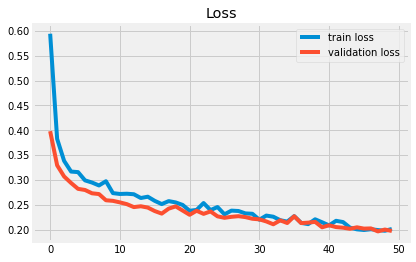

model learning accuracy 1/10


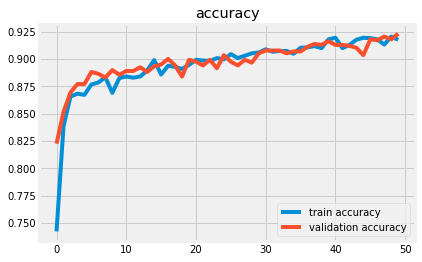

AUC1 0.9772263964121382


 10%|████████▌                                                                             | 1/10 [00:15<02:15, 15.05s/it]

model learning curve 2/10


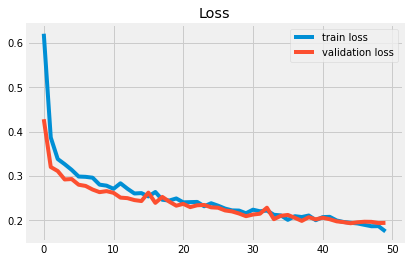

model learning accuracy 2/10


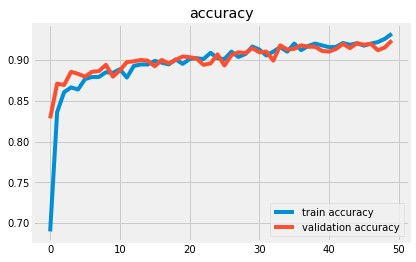

AUC1 0.9768649146534838


 20%|█████████████████▏                                                                    | 2/10 [00:25<01:48, 13.62s/it]

model learning curve 3/10


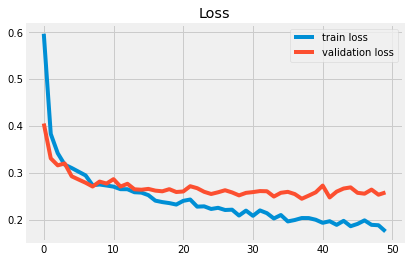

model learning accuracy 3/10


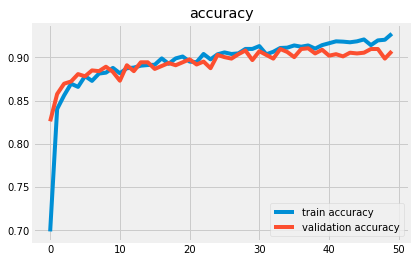

AUC1 0.9687956124314442


 30%|█████████████████████████▊                                                            | 3/10 [00:35<01:28, 12.65s/it]

model learning curve 4/10


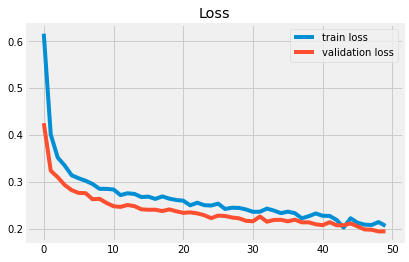

model learning accuracy 4/10


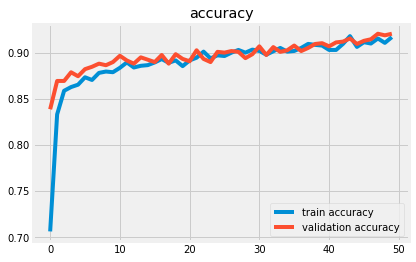

AUC1 0.9765721690764281


 40%|██████████████████████████████████▍                                                   | 4/10 [00:45<01:11, 11.88s/it]

model learning curve 5/10


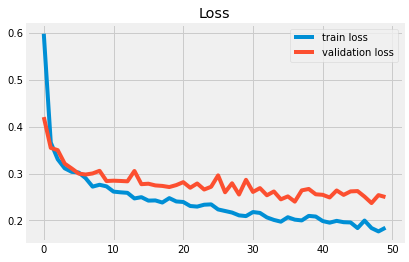

model learning accuracy 5/10


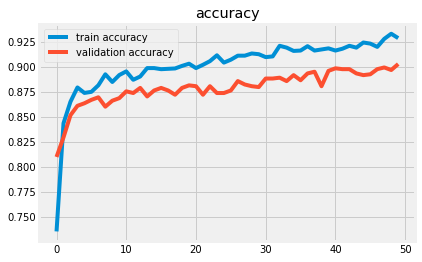

AUC1 0.9651392711017924


 50%|███████████████████████████████████████████                                           | 5/10 [00:55<00:56, 11.29s/it]

model learning curve 6/10


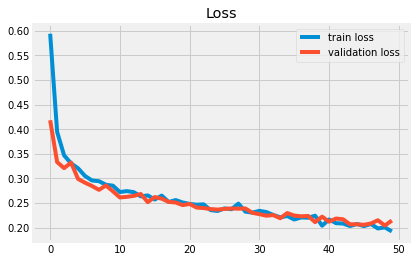

model learning accuracy 6/10


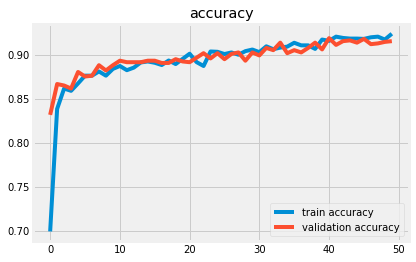

AUC1 0.9711538461538463


 60%|███████████████████████████████████████████████████▌                                  | 6/10 [01:05<00:43, 10.88s/it]

model learning curve 7/10


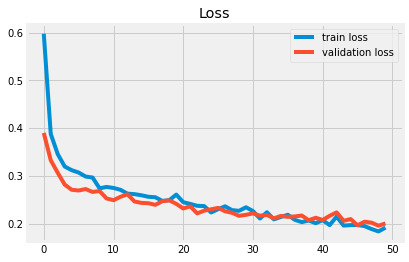

model learning accuracy 7/10


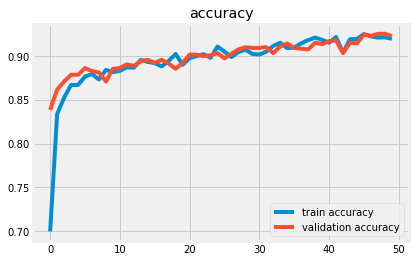

AUC1 0.9749180112816477


 70%|████████████████████████████████████████████████████████████▏                         | 7/10 [01:15<00:31, 10.62s/it]

model learning curve 8/10


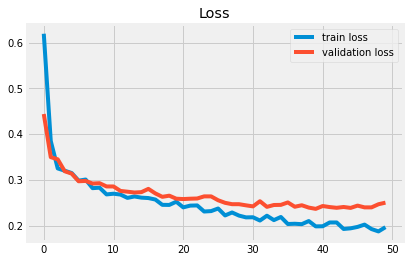

model learning accuracy 8/10


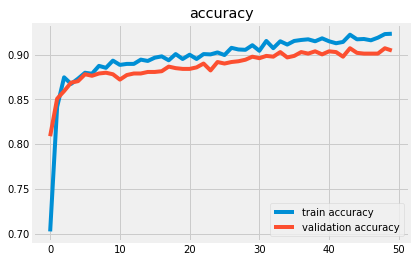

AUC1 0.9645278489163148


 80%|████████████████████████████████████████████████████████████████████▊                 | 8/10 [01:25<00:20, 10.40s/it]

model learning curve 9/10


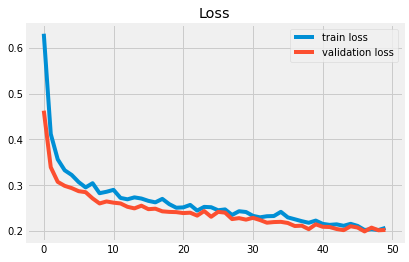

model learning accuracy 9/10


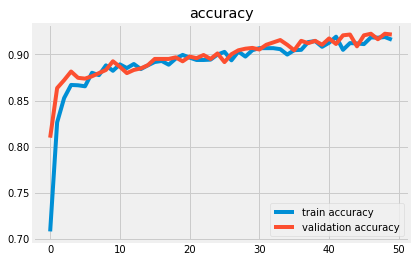

AUC1 0.9753236706514283


 90%|█████████████████████████████████████████████████████████████████████████████▍        | 9/10 [01:35<00:10, 10.29s/it]

model learning curve 10/10


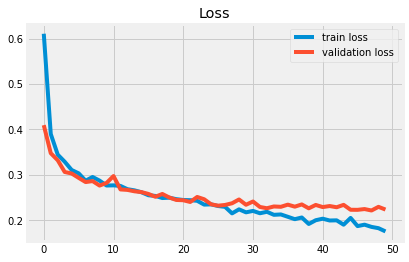

model learning accuracy 10/10


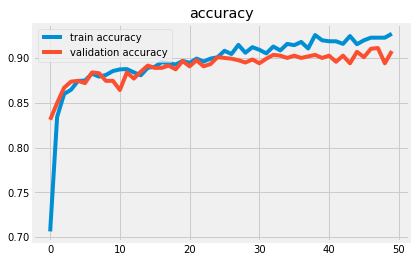

AUC1 0.9690441244991147


100%|█████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:45<00:00, 10.55s/it]


In [11]:
N = 10
#p = 3.5
preds1 = []
preds_train1 = []
aucs1 = []


for i in tqdm(range(N)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)

    X_train, X_test, y_train, y_test = train_test_split(train24, y_24, test_size=0.3, random_state=SEED)
    X_train_con1, X_test_con1, y_train, y_test = train_test_split(train_con1_24, y_24, test_size=0.3, random_state=SEED)
    X_train_con2, X_test_con2, y_train, y_test = train_test_split(train_con2_24, y_24, test_size = 0.3, random_state=SEED)

    input_data = Input(shape = (None, train24.shape[2]), name='X_data')
    input_con1 = Input(shape = (None, 2), name='con1')
    input_con2 = Input(shape = (None, 3), name='con2')

    in_1 = Conv1D(128, train24.shape[2]+5, strides=1, activation = 'relu', padding = 'same')(input_data)
    in_2 = Conv1D(128, train24.shape[2]+5, strides = 1, activation = 'relu', padding = 'same')(input_con1)
    in_3 = Conv1D(128, train24.shape[2]+5, strides=1, activation='relu', padding = 'same')(input_con2)

    in_1 = Dropout(0.5)(in_1)
    in_2 = Dropout(0.5)(in_2)
    in_3 = Dropout(0.5)(in_3)

    merge = concatenate([in_1, in_2, in_3])

    x = Conv1D(64, train24.shape[2]+5, strides = 1, activation='relu', padding='same')(merge)
    x = GlobalAveragePooling1D()(x)

    x = Dense(64, activation = 'relu')(x)
    x = Dense(32, activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation = 'relu')(x)
    out = Dense(1, activation = 'sigmoid', name = '24H')(x)

    
    model = Model([input_data, input_con1, input_con2], out)  
    
    # Choose the optimizer and the cost function
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    

    # Train the model
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]
    history = model.fit([X_train, X_train_con1, X_train_con2], y_train,
                    epochs = 50, 
                    batch_size = 64,
                    validation_data=([X_test, X_test_con1, X_test_con2],y_test),verbose=0)
    
    # Save Models
    #model.save(f'Model/model24_{i+1}.h5')
    
    print(f'model learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    print(f'model learning accuracy {i+1}/{N}')
    plt.plot(history.history["accuracy"], label="train accuracy")
    plt.plot(history.history["val_accuracy"], label="validation accuracy")
    plt.legend()
    plt.title("accuracy")
    plt.show()
    
    auc1 = roc_auc_score(y_test, model.predict([X_test, X_test_con1, X_test_con2]))
    aucs1.append(auc1)
    print('AUC1', auc1)
    
    preds1.append(model.predict([test24, test_con1, test_con2]))
    preds_train1.append(model.predict([train24, train_con1_24, train_con2_24]))

In [12]:
print('\nValidation Summary:')
auc1 = pd.Series(aucs1)
print(auc1.sort_values(ascending=False))
print('auc mean={:.5f}, auc std={:.3f}'.format(auc1.mean(), auc1.std())) 


Validation Summary:
0    0.977226
1    0.976865
3    0.976572
8    0.975324
6    0.974918
5    0.971154
9    0.969044
2    0.968796
4    0.965139
7    0.964528
dtype: float64
auc mean=0.97196, auc std=0.005


In [13]:
# Power mean ensemble
THRESHOLD = auc1[auc1.sort_values(ascending=False).index[0]] - auc1.std()  # Use only models whose AUC exceeds this value; Best Roc-Auc score in auc1 - std
p = 3.5
pred = pred_t = 0
n = 0
for i in range(N):
    if auc1.iloc[i] > THRESHOLD:
        pred = pred + preds1[i]**p 
        pred_t = pred_t + preds_train1[i]**p
        n += 1
pred = pred / n    
pred1 = pred**(1/p)
pred_t = pred_t / n
pred_t24 = pred_t**(1/p)

In [14]:
## predict Test Data
d_24 = []
for i in pred1:
  if i >= 0.5:
    d_24.append(1)
  else:
    d_24.append(0)

## predict Train Data(to calculate CSI)
train_p_24 = []
for i in pred_t24:
  if i >= 0.5:
    train_p_24.append(1)
  else:
    train_p_24.append(0)

#### save Threshold(24H)

In [15]:
#np.save('data/model24_Threshold.npy', auc1[auc1.sort_values(ascending=False).index[0]] - auc1.std())

### Model2 ###
 train and predict data using train48, train_con1_48, train_con2_48.

  0%|                                                                                              | 0/10 [00:00<?, ?it/s]

model learning curve 1/10


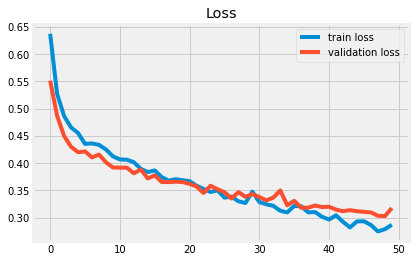

model learning accuracy 1/10


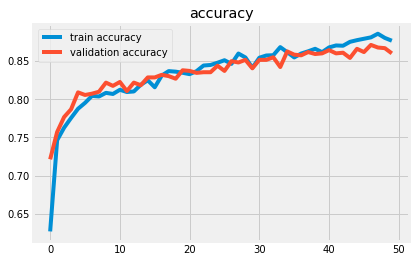

AUC2 0.9347651592264069


 10%|████████▌                                                                             | 1/10 [00:10<01:37, 10.81s/it]

model learning curve 2/10


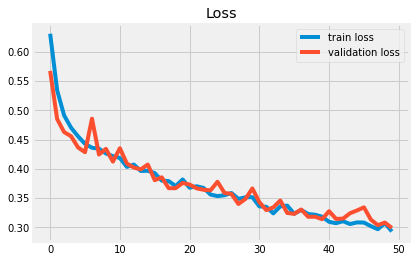

model learning accuracy 2/10


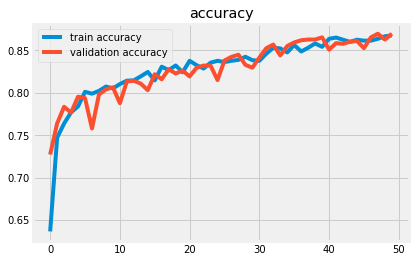

AUC2 0.9443599780970022


 20%|█████████████████▏                                                                    | 2/10 [00:21<01:26, 10.77s/it]

model learning curve 3/10


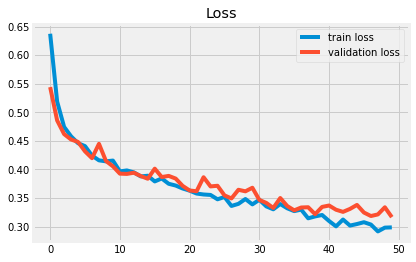

model learning accuracy 3/10


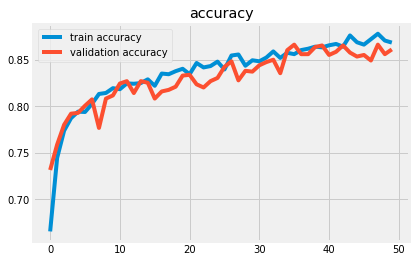

AUC2 0.9366060422820196


 30%|█████████████████████████▊                                                            | 3/10 [00:32<01:15, 10.81s/it]

model learning curve 4/10


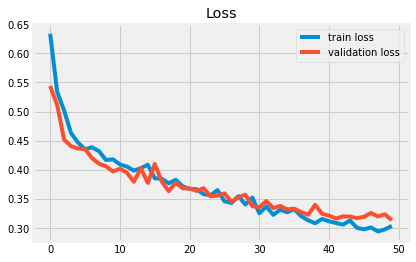

model learning accuracy 4/10


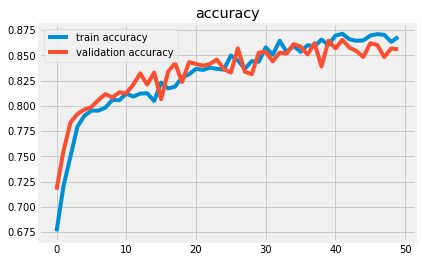

AUC2 0.9359577412377608


 40%|██████████████████████████████████▍                                                   | 4/10 [00:42<01:04, 10.67s/it]

model learning curve 5/10


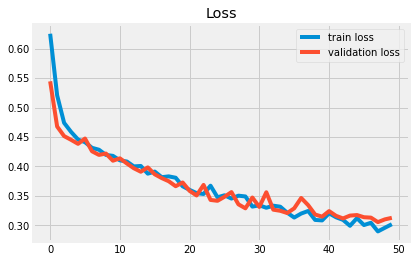

model learning accuracy 5/10


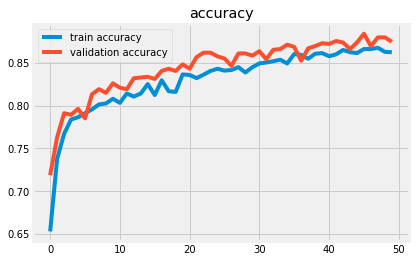

AUC2 0.9467713787085514


 50%|███████████████████████████████████████████                                           | 5/10 [00:52<00:52, 10.52s/it]

model learning curve 6/10


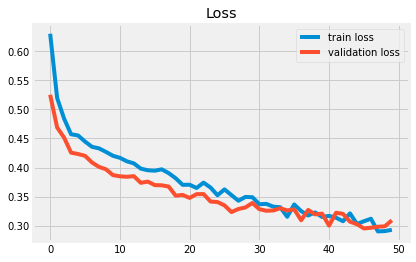

model learning accuracy 6/10


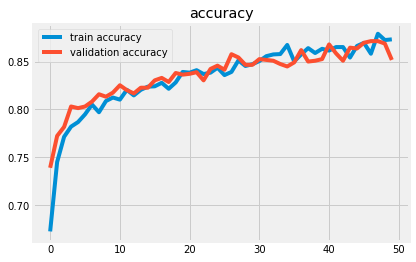

AUC2 0.9402312952066423


 60%|███████████████████████████████████████████████████▌                                  | 6/10 [01:03<00:41, 10.40s/it]

model learning curve 7/10


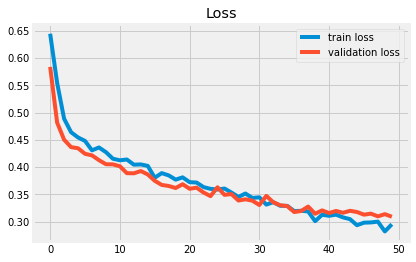

model learning accuracy 7/10


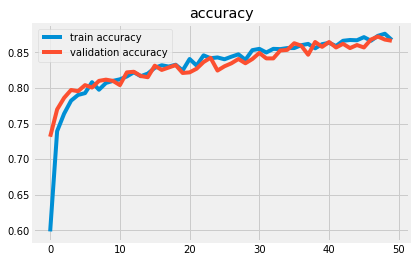

AUC2 0.941836598228874


 70%|████████████████████████████████████████████████████████████▏                         | 7/10 [01:13<00:31, 10.42s/it]

model learning curve 8/10


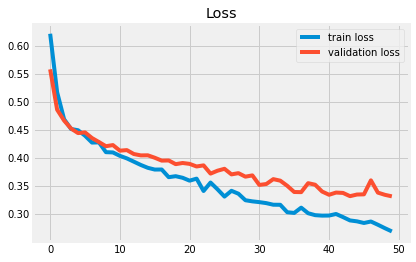

model learning accuracy 8/10


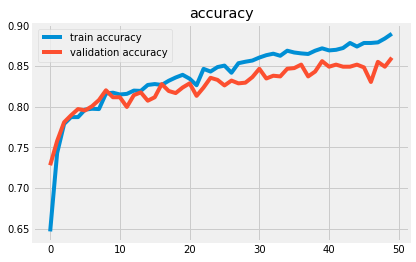

AUC2 0.9311510246856078


 80%|████████████████████████████████████████████████████████████████████▊                 | 8/10 [01:23<00:20, 10.41s/it]

model learning curve 9/10


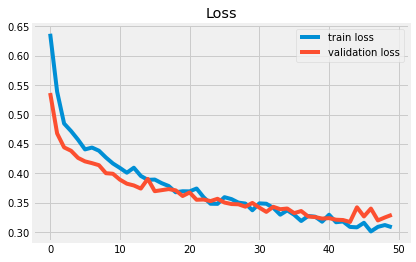

model learning accuracy 9/10


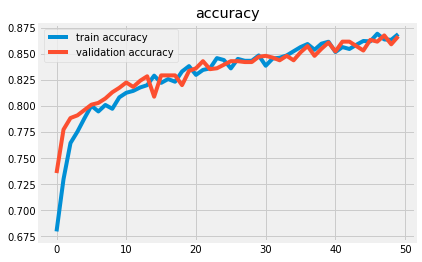

AUC2 0.9290723028171061


 90%|█████████████████████████████████████████████████████████████████████████████▍        | 9/10 [01:34<00:10, 10.37s/it]

model learning curve 10/10


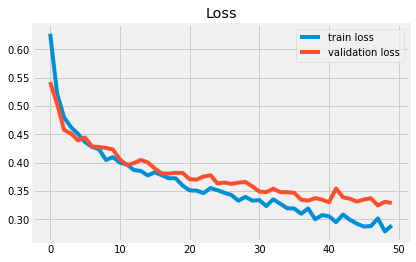

model learning accuracy 10/10


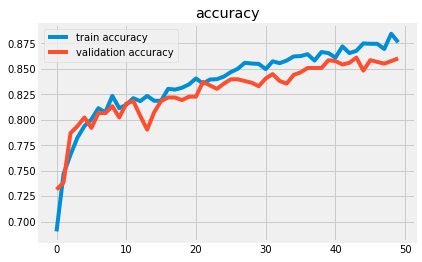

AUC2 0.929796203157252


100%|█████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:44<00:00, 10.42s/it]


In [16]:
N = 10
#p = 3.5
preds2 = []
aucs2 = []
preds_train2 = []


for i in tqdm(range(N)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)

    X_train, X_test, y_train, y_test = train_test_split(train48, y_48, test_size=0.3, random_state=SEED)
    X_train_con1, X_test_con1, y_train, y_test = train_test_split(train_con1_48, y_48, test_size=0.3, random_state=SEED)
    X_train_con2, X_test_con2, y_train, y_test = train_test_split(train_con2_48, y_48, test_size = 0.3, random_state=SEED)

    input_data = Input(shape = (None, train48.shape[2]), name='X_data')
    input_con1 = Input(shape = (None, 2), name='con1')
    input_con2 = Input(shape = (None, 3), name='con2')

    in_1 = Conv1D(128, train48.shape[2]+5, strides=1, activation = 'relu', padding = 'same')(input_data)
    in_2 = Conv1D(128, train48.shape[2]+5, strides = 1, activation = 'relu', padding = 'same')(input_con1)
    in_3 = Conv1D(128, train48.shape[2]+5, strides=1, activation='relu', padding = 'same')(input_con2)

    in_1 = Dropout(0.5)(in_1)
    in_2 = Dropout(0.5)(in_2)
    in_3 = Dropout(0.5)(in_3)

    merge = concatenate([in_1, in_2, in_3])

    x = Conv1D(64, train48.shape[2]+5, strides = 1, activation='relu', padding='same')(merge)
    x = GlobalAveragePooling1D()(x)

    x = Dense(64, activation = 'relu')(x)
    x = Dense(32, activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation = 'relu')(x)
    out = Dense(1, activation = 'sigmoid', name = '48H')(x)

    
    model = Model([input_data, input_con1, input_con2], out)  
    
    # Choose the optimizer and the cost function
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Train the model
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]
    history = model.fit([X_train, X_train_con1, X_train_con2], y_train,
                    epochs = 50, 
                    batch_size = 64,
                    validation_data=([X_test, X_test_con1, X_test_con2],y_test),verbose=0)
    
    # Save Models
    #model.save(f'Model/model48_{i+1}.h5')
    
    print(f'model learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    print(f'model learning accuracy {i+1}/{N}')
    plt.plot(history.history["accuracy"], label="train accuracy")
    plt.plot(history.history["val_accuracy"], label="validation accuracy")
    plt.legend()
    plt.title("accuracy")
    plt.show()
    
    auc2 = roc_auc_score(y_test, model.predict([X_test, X_test_con1, X_test_con2]))
    aucs2.append(auc2)
    print('AUC2', auc2)
    
    preds2.append(model.predict([test48, test_con1, test_con2]))
    preds_train2.append(model.predict([train48, train_con1_48, train_con2_48]))

In [17]:
print('\nValidation Summary:')
auc2 = pd.Series(aucs2)
print(auc2.sort_values(ascending=False))
print('auc mean={:.5f}, auc std={:.3f}'.format(auc2.mean(), auc2.std())) 


Validation Summary:
4    0.946771
1    0.944360
6    0.941837
5    0.940231
2    0.936606
3    0.935958
0    0.934765
7    0.931151
9    0.929796
8    0.929072
dtype: float64
auc mean=0.93705, auc std=0.006


In [18]:
# Power mean ensemble
THRESHOLD = auc2[auc2.sort_values(ascending=False).index[0]] - auc2.std()  # Use only models whose AUC exceeds this value; Best Roc-Auc score in auc2 - std
p = 3.5
pred = pred_t = 0
n = 0
for i in range(N):
    if auc2.iloc[i] > THRESHOLD:
        pred = pred + preds2[i]**p 
        pred_t = pred_t + preds_train2[i]**p
        n += 1
pred = pred / n    
pred2 = pred**(1/p)
pred_t = pred_t / n
pred_t48 = pred_t**(1/p)

In [19]:
## Predict Test Data
d_48 = []
for i in pred2:
  if i >= 0.5:
    d_48.append(1)
  else:
    d_48.append(0)

## Predict Train Data to calculate CSI
train_p_48 = []
for i in pred_t48:
  if i >= 0.5:
    train_p_48.append(1)
  else:
    train_p_48.append(0)

#### save Threshold(48H)

In [20]:
#np.save('data/model48_Threshold.npy', auc2[auc2.sort_values(ascending=False).index[0]] - auc2.std())

## Predict Data with loaded Models ## 

모델링하는 과정에서 저장한 모델들 중에서 rocauc가 Threshold 이상인 모델들만 불러온 후 모델들로 예측하여 나온 값들을 Gmean으로 Ensemble. 

#### Model1 ####
model24_0, model24_4, model24_7, model24_8, model24_9 총 5개의 모델로 24H 예측

In [21]:
Threshold_24 = np.load('data/model24_Threshold.npy')

int24 = auc1[auc1 > Threshold_24].index # model의 index 번호(0,4,7,8,9)
models_24 = ['model24_0.h5','model24_1.h5','model24_2.h5','model24_3.h5','model24_4.h5',
             'model24_5.h5','model24_6.h5','model24_7.h5','model24_8.h5','model24_9.h5']

loaded_model24 = [] # 불러온 모델을 담을 리스트
for i in int24:
  for j in range(len(models_24)):
    if i == int(models_24[j][8]):
      m = globals()['model{}'.format(i)]= load_model('Model/' + models_24[j])
      print('model{} is completely loaded.'.format(i))
      loaded_model24.append(m) # 불러온 모델 리스트에 추가

model0 is completely loaded.
model1 is completely loaded.
model3 is completely loaded.
model8 is completely loaded.


In [22]:
prediction24 = []
for i in range(len(loaded_model24)):
  prediction24.append(loaded_model24[i].predict([test24, test_con1, test_con2]))

pred_final_24 = gmean(prediction24, axis=0)

In [23]:
d_24 = []
for i in pred_final_24:
  if i >= 0.5:
    d_24.append(1)
  else:
    d_24.append(0)

#### Model2 ####
 model48_1, model48_4, model48_5, model48_8 총 4개의 모델로 48H 예측

In [24]:
Threshold_48 = np.load('data/model48_Threshold.npy')

int48 = auc2[auc2 > Threshold_48].index # model의 index 번호(1,4,5,8)
models_48 = ['model48_0.h5','model48_1.h5','model48_2.h5','model48_3.h5','model48_4.h5',
             'model48_5.h5','model48_6.h5','model48_7.h5','model48_8.h5','model48_9.h5']

loaded_model48 = []
for i in int48:
  for j in range(len(models_48)):
    if i == int(models_48[j][8]):
      m = globals()['model{}'.format(i)]= load_model('Model/' + models_48[j])
      print('model{} is completely loaded.'.format(i))
      loaded_model48.append(m)


model1 is completely loaded.
model4 is completely loaded.
model6 is completely loaded.


In [25]:
prediction48 = []
for i in range(len(loaded_model48)):
  prediction48.append(loaded_model48[i].predict([test48, test_con1, test_con2]))

pred_final_48 = gmean(prediction48, axis=0)

In [26]:
d_48 = []
for i in pred_final_48:
  if i >= 0.5:
    d_48.append(1)
  else:
    d_48.append(0)

## Performance Test ##
Train set에 모델을 적용하여 나온 예측값으로 성능 확인

In [27]:
print(tf.math.confusion_matrix(train_label_24, train_p_24, num_classes=2))
print(tf.math.confusion_matrix(train_label_48, train_p_48, num_classes=2))

tf.Tensor(
[[1779  174]
 [  72 1881]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[1614  340]
 [  91 1863]], shape=(2, 2), dtype=int32)


In [28]:
def CSI(label, pred):
    cm = tf.math.confusion_matrix(label, pred, num_classes=2)
    a = cm[0][1]
    b = cm[1][0]
    c = cm[1][1]
    
    print((c/(a+b+c))*100)

In [29]:
CSI(train_label_24, train_p_24)
CSI(train_label_48, train_p_48)

tf.Tensor(88.43441466854725, shape=(), dtype=float64)
tf.Tensor(81.21185701830863, shape=(), dtype=float64)


## Save predictions to csv ##

In [30]:
sub = pd.read_csv('data/참가번호6자리.csv')

In [31]:
sub['X24H_COND_LOC'] = d_24
sub['X24H_COND_LOC_PROB'] = pred_final_24
sub['X48H_COND_LOC'] = d_48
sub['X48H_COND_LOC_PROB'] = pred_final_48

In [32]:
sub

,MEA_DDHR,PLANT,LOC,X24H_TMA,X24H_COND_LOC,X24H_COND_LOC_PROB,X48H_TMA,X48H_COND_LOC,X48H_COND_LOC_PROB
0,2019-04-01 0:00,2,3,2019-04-02 0:00,0,0.001854,2019-04-03 0:00,0,0.173284
1,2019-04-01 4:30,1,2,2019-04-02 4:30,0,0.044181,2019-04-03 4:30,0,0.105396
2,2019-04-01 10:30,2,3,2019-04-02 10:30,0,0.000235,2019-04-03 10:30,0,0.008233
3,2019-04-01 11:00,1,1,2019-04-02 11:00,0,0.000236,2019-04-03 11:00,0,0.004301
4,2019-04-01 13:30,2,1,2019-04-02 13:30,0,0.000047,2019-04-03 13:30,0,0.005785
...,...,...,...,...,...,...,...,...,...
3534,2020-03-29 3:00,1,2,2020-03-30 3:00,0,0.000101,2020-03-31 3:00,0,0.012480
3535,2020-03-29 5:00,2,3,2020-03-30 5:00,0,0.000612,2020-03-31 5:00,0,0.062217
3536,2020-03-29 7:00,2,1,2020-03-30 7:00,0,0.006114,2020-03-31 7:00,0,0.348189
3537,2020-03-29 11:30,1,1,2020-03-30 11:30,0,0.164812,2020-03-31 11:30,0,0.019009


In [33]:
mydf=sub.to_csv('submission/203608.csv', index=False, encoding='cp949')